In [1]:
import numpy as np
import seaborn as sns
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
from pydataset import data
import os
from acquire import get_titanic_data
from prepare import clean_titanic
from env import host,db,protocol,password,user,mysqlcon

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
import acquire
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

########## AQUIRE ##########

In [2]:
###used get_telco data function from acquire.py to pull from mysql 
## or a local file if you already have it on your system
def get_telco_data():
    filenametelco = "telco.csv"
    mysqlcon=f"{protocol}://{user}:{password}@{host}/{db}"

    if os.path.isfile(filenametelco):
        return pd.read_csv(filenametelco)
    else:
        # read the SQL query into a dataframe
        df_telco_churn = pd.read_sql_query(
'''select * from customers
left join contract_types
using(contract_type_id)
left join internet_service_types
using (internet_service_type_id)
left join payment_types
using (payment_type_id)
left join customer_churn
using (customer_id);''', mysqlcon)

        # Write that dataframe to disk for later. Called "caching" the data for later.
        df_telco_churn.to_csv(filenametelco)

        # Return the dataframe to the calling code
        return df_telco_churn

In [87]:
#stored the telco data into a variable df
df = get_telco_data()

In [4]:
#called the variable to get a look at our telco data. 
df

,Unnamed: 0,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,...,Yes,Yes,No,Yes,65.60,593.3,No,One year,DSL,Mailed check
1,1,2,1,1,0003-MKNFE,Male,0,No,No,9,...,No,No,Yes,No,59.90,542.4,No,Month-to-month,DSL,Mailed check
2,2,1,2,1,0004-TLHLJ,Male,0,No,No,4,...,No,No,No,Yes,73.90,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,3,1,2,1,0011-IGKFF,Male,1,Yes,No,13,...,No,Yes,Yes,Yes,98.00,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,...,Yes,Yes,No,Yes,83.90,267.4,Yes,Month-to-month,Fiber optic,Mailed check
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,7038,2,1,2,9987-LUTYD,Female,0,No,No,13,...,Yes,No,No,No,55.15,742.9,No,One year,DSL,Mailed check
7039,7039,1,2,1,9992-RRAMN,Male,0,Yes,No,22,...,No,No,Yes,Yes,85.10,1873.7,Yes,Month-to-month,Fiber optic,Electronic check
7040,7040,2,1,1,9992-UJOEL,Male,0,No,No,2,...,No,No,No,Yes,50.30,92.75,No,Month-to-month,DSL,Mailed check
7041,7041,2,1,3,9993-LHIEB,Male,0,Yes,Yes,67,...,Yes,No,Yes,No,67.85,4627.65,No,Two year,DSL,Mailed check


In [5]:
#pulled info about the dataset columns, non_null, dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                7043 non-null   int64  
 1   payment_type_id           7043 non-null   int64  
 2   internet_service_type_id  7043 non-null   int64  
 3   contract_type_id          7043 non-null   int64  
 4   customer_id               7043 non-null   object 
 5   gender                    7043 non-null   object 
 6   senior_citizen            7043 non-null   int64  
 7   partner                   7043 non-null   object 
 8   dependents                7043 non-null   object 
 9   tenure                    7043 non-null   int64  
 10  phone_service             7043 non-null   object 
 11  multiple_lines            7043 non-null   object 
 12  online_security           7043 non-null   object 
 13  online_backup             7043 non-null   object 
 14  device_p

In [6]:
#pulled a summary of the data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,7043.0,3521.000000,2033.283305,0.00,1760.5,3521.00,5281.50,7042.00
payment_type_id,7043.0,2.315633,1.148907,1.00,1.0,2.00,3.00,4.00
internet_service_type_id,7043.0,1.872923,0.737796,1.00,1.0,2.00,2.00,3.00
contract_type_id,7043.0,1.690473,0.833755,1.00,1.0,1.00,2.00,3.00
senior_citizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
monthly_charges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


In [7]:
#checked for null values
df.isna().sum()


Unnamed: 0                  0
payment_type_id             0
internet_service_type_id    0
contract_type_id            0
customer_id                 0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
phone_service               0
multiple_lines              0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
paperless_billing           0
monthly_charges             0
total_charges               0
churn                       0
contract_type               0
internet_service_type       0
payment_type                0
dtype: int64

########## PREPARE ##########

In [8]:
obj_cols = df.columns[[df[col].dtype == 'O' for col in df.columns]]

In [9]:
obj_cols

Index(['customer_id', 'gender', 'partner', 'dependents', 'phone_service',
       'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'total_charges', 'churn', 'contract_type',
       'internet_service_type', 'payment_type'],
      dtype='object')

In [10]:
 for col in obj_cols:
    print(df[col].value_counts())
    print(df[col].value_counts(normalize=True, dropna=False))
    print('----------------------')

0002-ORFBO    1
6616-AALSR    1
6625-UTXEW    1
6625-IUTTT    1
6625-FLENO    1
             ..
3352-RICWQ    1
3352-ALMCK    1
3351-NQLDI    1
3351-NGXYI    1
9995-HOTOH    1
Name: customer_id, Length: 7043, dtype: int64
0002-ORFBO    0.000142
6616-AALSR    0.000142
6625-UTXEW    0.000142
6625-IUTTT    0.000142
6625-FLENO    0.000142
                ...   
3352-RICWQ    0.000142
3352-ALMCK    0.000142
3351-NQLDI    0.000142
3351-NGXYI    0.000142
9995-HOTOH    0.000142
Name: customer_id, Length: 7043, dtype: float64
----------------------
Male      3555
Female    3488
Name: gender, dtype: int64
Male      0.504756
Female    0.495244
Name: gender, dtype: float64
----------------------
No     3641
Yes    3402
Name: partner, dtype: int64
No     0.516967
Yes    0.483033
Name: partner, dtype: float64
----------------------
No     4933
Yes    2110
Name: dependents, dtype: int64
No     0.700412
Yes    0.299588
Name: dependents, dtype: float64
----------------------
Yes    6361
No      682
Nam

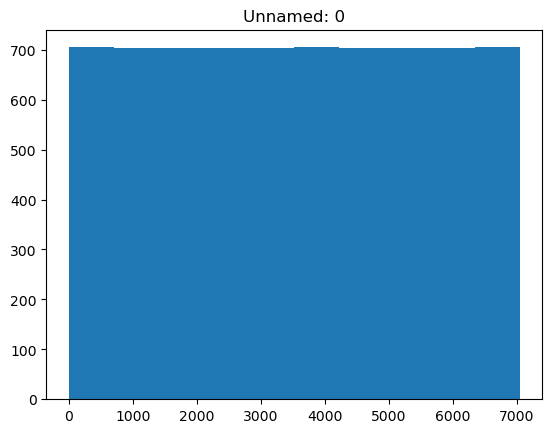

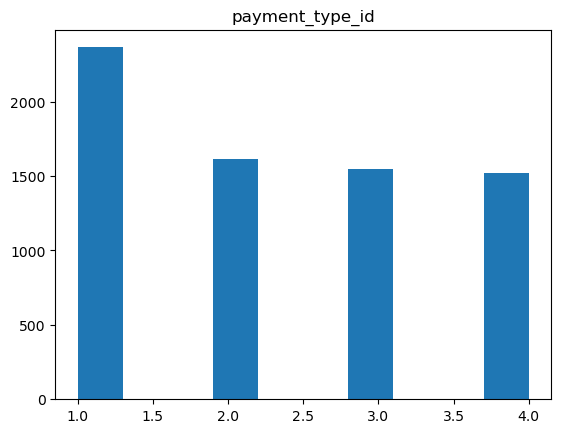

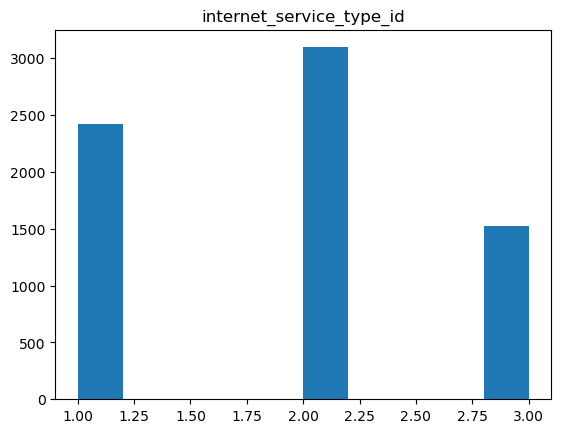

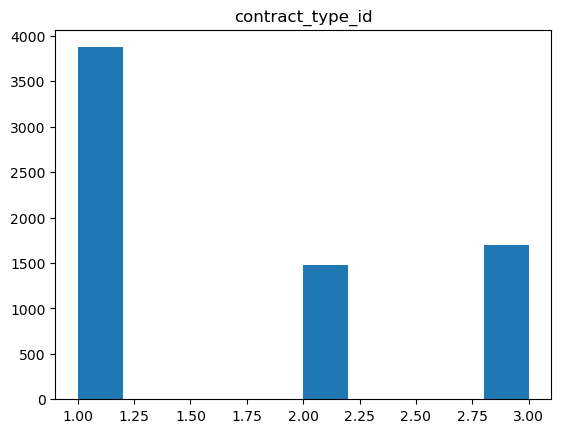

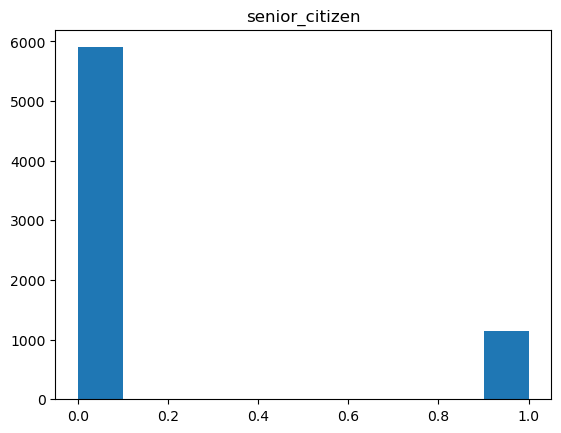

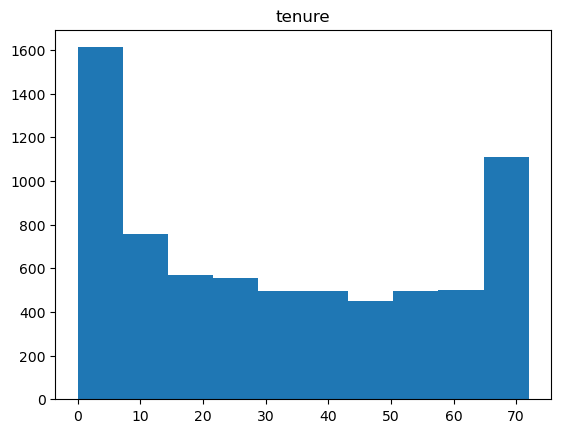

In [11]:
num_cols = df.columns[[df[col].dtype == 'int64' for col in df.columns]]
for col in num_cols:
        plt.hist(df[col])
        plt.title(col)
        plt.show()

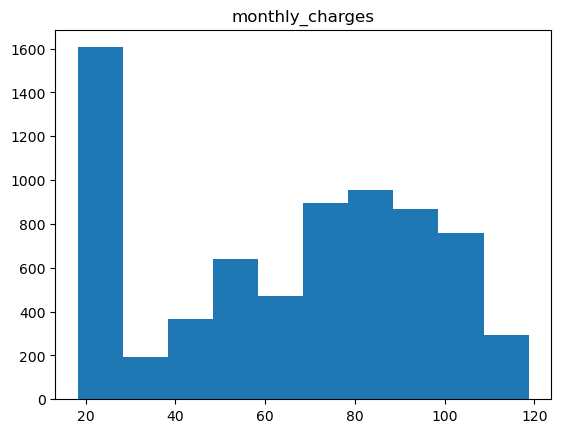

In [12]:
num_cols = df.columns[[df[col].dtype == 'float64' for col in df.columns]]
for col in num_cols:
        plt.hist(df[col])
        plt.title(col)
        plt.show()

In [13]:
df[obj_cols].drop_duplicates().nunique()

customer_id              7043
gender                      2
partner                     2
dependents                  2
phone_service               2
multiple_lines              3
online_security             3
online_backup               3
device_protection           3
tech_support                3
streaming_tv                3
streaming_movies            3
paperless_billing           2
total_charges            6531
churn                       2
contract_type               3
internet_service_type       3
payment_type                4
dtype: int64

def prep_teco(df):
       '''
    take in telco dataframe, drop the repeat columns, 
    get dummy variables for all remaining object columns, 
    and drop original obj columns after dummy variables are created. 
    '''
    df = df.drop(columns=['customer_id', 'contract_type_id', 'payment_type_id', 'internet_service_type_id'])

    dummy_df = pd.get_dummies(df[['gender', 'partner', 'dependents','tech_support','streaming_tv','streaming_movies','paperless_billing','churn','contract_type','internet_service_type', 'payment_type']], 
                              prefix=['gender', 'partner', 'dependents','tech_s','streaming_tv','streaming_movies','paperless_billing','churn','contract_type','internet_service_type', 'payment_type'])

    df = pd.concat([df, dummy_df.drop(columns=['gender_male'])], axis=1)

    df = df.drop(columns=['gender', 'partner', 'dependents','tech_support','streaming_tv','streaming_movies','paperless_billing','churn','contract_type','internet_service_type', 'payment_type']) 

    # Drop duplicates...run just in case; reassign and check the shape of my data.
    df = df.drop_duplicates()

    return df
    

In [14]:
df

,Unnamed: 0,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,...,Yes,Yes,No,Yes,65.60,593.3,No,One year,DSL,Mailed check
1,1,2,1,1,0003-MKNFE,Male,0,No,No,9,...,No,No,Yes,No,59.90,542.4,No,Month-to-month,DSL,Mailed check
2,2,1,2,1,0004-TLHLJ,Male,0,No,No,4,...,No,No,No,Yes,73.90,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,3,1,2,1,0011-IGKFF,Male,1,Yes,No,13,...,No,Yes,Yes,Yes,98.00,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,...,Yes,Yes,No,Yes,83.90,267.4,Yes,Month-to-month,Fiber optic,Mailed check
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,7038,2,1,2,9987-LUTYD,Female,0,No,No,13,...,Yes,No,No,No,55.15,742.9,No,One year,DSL,Mailed check
7039,7039,1,2,1,9992-RRAMN,Male,0,Yes,No,22,...,No,No,Yes,Yes,85.10,1873.7,Yes,Month-to-month,Fiber optic,Electronic check
7040,7040,2,1,1,9992-UJOEL,Male,0,No,No,2,...,No,No,No,Yes,50.30,92.75,No,Month-to-month,DSL,Mailed check
7041,7041,2,1,3,9993-LHIEB,Male,0,Yes,Yes,67,...,Yes,No,Yes,No,67.85,4627.65,No,Two year,DSL,Mailed check


In [15]:
df[['payment_type','payment_type_id']].value_counts()

payment_type               payment_type_id
Electronic check           1                  2365
Mailed check               2                  1612
Bank transfer (automatic)  3                  1544
Credit card (automatic)    4                  1522
dtype: int64

In [16]:
def prep_telco(df):
    df = df.drop(columns=['customer_id', 'contract_type_id', 'payment_type_id', 'internet_service_type_id'])
    dummy_df = pd.get_dummies(df[['gender', 'partner', 'dependents', 'phone_service',
       'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'total_charges', 'churn', 'contract_type',
       'internet_service_type', 'payment_type']], 
                              prefix=['gender', 'partner', 'dependents', 'phone_service',
       'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'total_charges', 'churn', 'contract_type',
       'internet_service_type', 'payment_type'])
    
    df = pd.concat([df, dummy_df.drop(columns=['gender_Female','partner_No','dependents_No','internet_service_type_None','churn_No','paperless_billing_No','streaming_movies_No','streaming_tv_No','tech_support_No','phone_service_No','device_protection_No','online_security_No','online_backup_No','multiple_lines_No','multiple_lines_No phone service','online_security_No internet service'])], axis=1)
   

    df = df.drop(columns=['gender', 'partner', 'dependents', 'phone_service',
       'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'total_charges', 'churn', 'contract_type',
       'internet_service_type', 'payment_type'])
    df = df.drop_duplicates()
    df.columns = [col.lower()for col in df]
    return df


 

In [17]:
df=prep_telco(df)

In [18]:
df

,unnamed: 0,senior_citizen,tenure,monthly_charges,gender_male,partner_yes,dependents_yes,phone_service_yes,multiple_lines_yes,online_security_yes,...,churn_yes,contract_type_month-to-month,contract_type_one year,contract_type_two year,internet_service_type_dsl,internet_service_type_fiber optic,payment_type_bank transfer (automatic),payment_type_credit card (automatic),payment_type_electronic check,payment_type_mailed check
0,0,0,9,65.60,0,1,1,1,0,0,...,0,0,1,0,1,0,0,0,0,1
1,1,0,9,59.90,1,0,0,1,1,0,...,0,1,0,0,1,0,0,0,0,1
2,2,0,4,73.90,1,0,0,1,0,0,...,1,1,0,0,0,1,0,0,1,0
3,3,1,13,98.00,1,1,0,1,0,0,...,1,1,0,0,0,1,0,0,1,0
4,4,1,3,83.90,0,1,0,1,0,0,...,1,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,7038,0,13,55.15,0,0,0,1,0,1,...,0,0,1,0,1,0,0,0,0,1
7039,7039,0,22,85.10,1,1,0,1,1,0,...,1,1,0,0,0,1,0,0,1,0
7040,7040,0,2,50.30,1,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,1
7041,7041,0,67,67.85,1,1,1,1,0,1,...,0,0,0,1,1,0,0,0,0,1


In [19]:
df.head()

,unnamed: 0,senior_citizen,tenure,monthly_charges,gender_male,partner_yes,dependents_yes,phone_service_yes,multiple_lines_yes,online_security_yes,...,churn_yes,contract_type_month-to-month,contract_type_one year,contract_type_two year,internet_service_type_dsl,internet_service_type_fiber optic,payment_type_bank transfer (automatic),payment_type_credit card (automatic),payment_type_electronic check,payment_type_mailed check
0,0,0,9,65.6,0,1,1,1,0,0,...,0,0,1,0,1,0,0,0,0,1
1,1,0,9,59.9,1,0,0,1,1,0,...,0,1,0,0,1,0,0,0,0,1
2,2,0,4,73.9,1,0,0,1,0,0,...,1,1,0,0,0,1,0,0,1,0
3,3,1,13,98.0,1,1,0,1,0,0,...,1,1,0,0,0,1,0,0,1,0
4,4,1,3,83.9,0,1,0,1,0,0,...,1,1,0,0,0,1,0,0,0,1


In [20]:
#define function to train, valideate, test, split the data. 
def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test


In [21]:
# sort data with categorical target variables
train, validate, test = train_validate_test_split(df, target='churn_yes')

In [22]:
train.shape, validate.shape, test.shape

((3943, 6562), (1691, 6562), (1409, 6562))

In [23]:
#even proportions of the target in each dataset. 
train.churn_yes.mean(), validate.churn_yes.mean(), test.churn_yes.mean()

(0.2652802434694395, 0.26552335895919577, 0.2654364797728886)

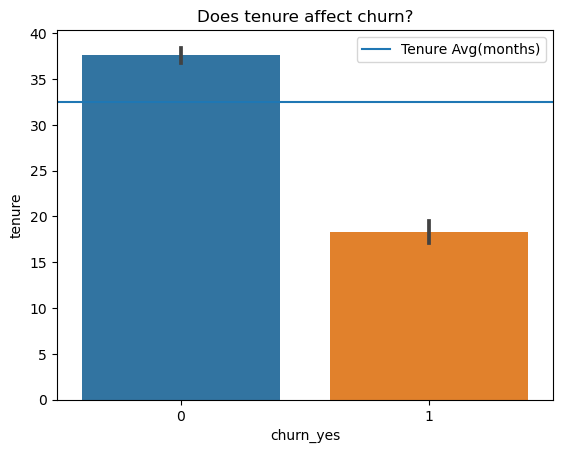

In [24]:
plt.title("Does tenure affect churn?")
sns.barplot(x="churn_yes", y="tenure", data=train)
avg_months_tenure = train.tenure.mean()
plt.axhline(avg_months_tenure, label="Tenure Avg(months)")
plt.legend()
plt.show()


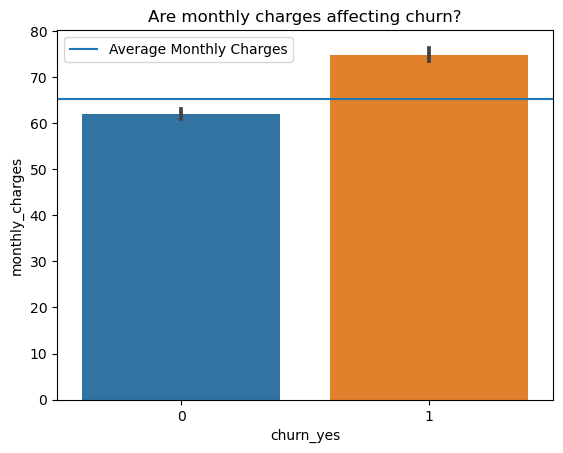

In [25]:
plt.title("Are monthly charges affecting churn?")
sns.barplot(x="churn_yes", y="monthly_charges", data=train)
monthly_charges_avg = train.monthly_charges.mean()
plt.axhline(monthly_charges_avg, label="Average Monthly Charges")
plt.legend()
plt.show()

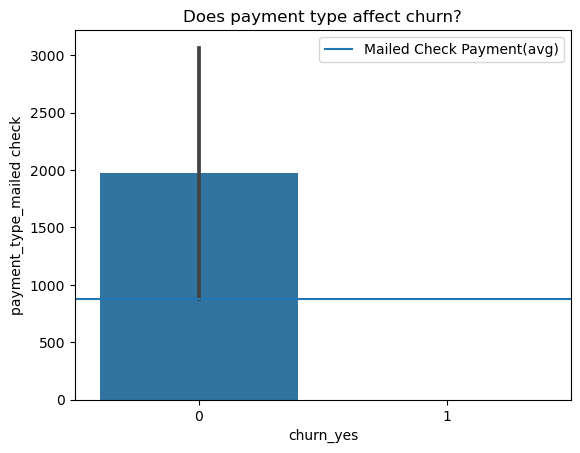

In [26]:
plt.title("Does payment type affect churn?")
sns.barplot(x='churn_yes', y=train['payment_type_mailed check'].value_counts(), data=train)
mailed_payment_avg = train['payment_type_mailed check'].value_counts().min()
plt.axhline(mailed_payment_avg, label="Mailed Check Payment(avg)")
plt.legend()
plt.show()

In [27]:
####return if time permits and show the correlation of mailed payments and churn. 

In [28]:
pd.crosstab(train.churn_yes, train['monthly_charges'])

monthly_charges,18.25,18.40,18.55,18.75,18.80,18.85,18.95,19.00,19.05,19.10,...,116.75,116.85,117.20,117.45,117.50,118.20,118.35,118.60,118.65,118.75
churn_yes,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,3,1,6,6,5,...,1,1,1,0,1,1,0,2,1,1
1,0,0,0,0,0,1,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0


In [29]:
# Let's run a chi squared to compare proportions, to have more confidence
alpha = 0.05
null_hypothesis = "monthly charges and churn are independent "
alternative_hypothesis = "there is a relationship between churn and monthly charges"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train.churn_yes, train.monthly_charges)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")
p


Reject the null hypothesis that monthly charges and churn are independent 
Sufficient evidence to move forward understanding that there is a relationship between churn and monthly charges


4.831992932196519e-06

In [30]:
pd.crosstab(train.churn_yes, train['payment_type_mailed check'])

payment_type_mailed check,0,1
churn_yes,,
0,2196,701
1,870,176


In [31]:
#chi squared to compare proportions, to have more confidence
alpha = 0.05
null_hypothesis = "mailed check payment and churn are independent "
alternative_hypothesis = "there is a relationship between churn and mailed check payment"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train.churn_yes, train['payment_type_mailed check'])

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")
p


Reject the null hypothesis that mailed check payment and churn are independent 
Sufficient evidence to move forward understanding that there is a relationship between churn and mailed check payment


1.1133895300866647e-06

In [32]:
pd.crosstab(train.churn_yes, train.tenure)

tenure,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,72
churn_yes,,,,,,,,,,,,,,,,,,,,,
0,8,121,60,56,54,32,45,47,43,45,...,36,38,39,44,44,52,47,63,94,204
1,0,212,72,49,44,29,19,33,21,24,...,2,1,5,8,7,3,2,5,5,3


In [33]:
#chi squared to compare proportions, to have more confidence
alpha = 0.05
null_hypothesis = "tenure and churn are independent "
alternative_hypothesis = "there is a relationship between churn and tenure"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train.churn_yes, train['tenure'])

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")
p


Reject the null hypothesis that tenure and churn are independent 
Sufficient evidence to move forward understanding that there is a relationship between churn and tenure


5.02386494439766e-89

In [34]:
#Mann-Whitney test
churned = train[train.churn_yes == 1]
not_churned = train[train.churn_yes == 0]

In [35]:
not_churned.monthly_charges.var(), churned.monthly_charges.var()

(975.0822609888156, 629.0650841048611)

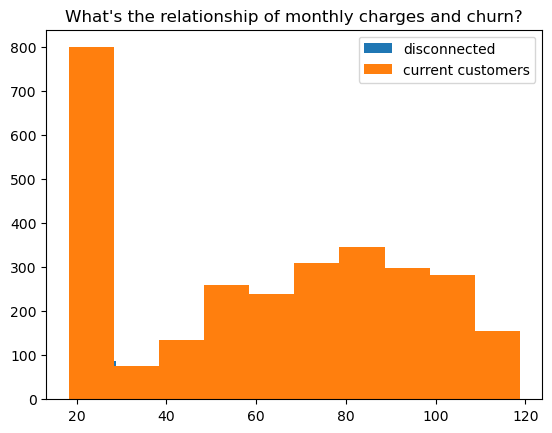

In [36]:
plt.title("What's the relationship of monthly charges and churn?")
plt.hist(churned.monthly_charges, label="disconnected")
plt.hist(not_churned.monthly_charges, label="current customers")
plt.legend()
plt.show()


In [37]:
not_churned['payment_type_mailed check'].var(), churned['payment_type_mailed check'].var()

(0.1834861554246439, 0.14008251987521383)

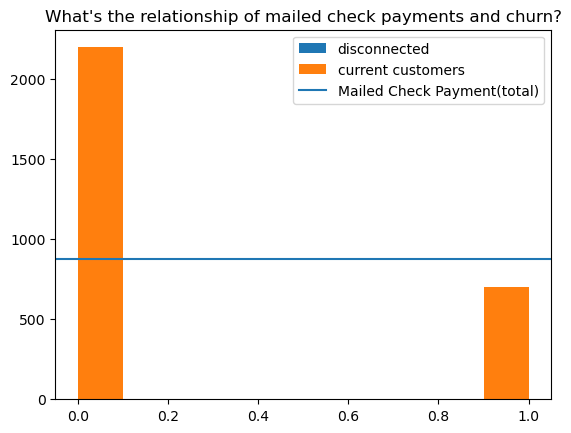

In [38]:
plt.title("What's the relationship of mailed check payments and churn?")
plt.hist(churned['payment_type_mailed check'], label="disconnected")
plt.hist(not_churned['payment_type_mailed check'], label="current customers")
total_mailed_checkpayments = train['payment_type_mailed check'].value_counts().min()
plt.axhline(total_mailed_checkpayments, label="Mailed Check Payment(total)")
plt.legend()
plt.show()


In [39]:
not_churned.tenure.var(), churned.tenure.var()

(582.3144672904131, 387.6968583896706)

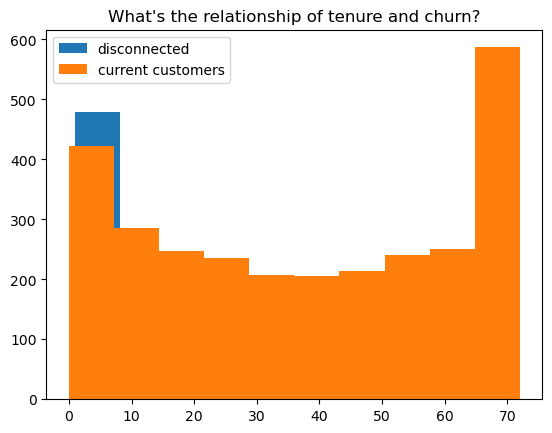

In [40]:
plt.title("What's the relationship of tenure and churn?")
plt.hist(churned.tenure, label="disconnected")
plt.hist(not_churned.tenure, label="current customers")
plt.legend()
plt.show()

###### Modeling ######

In [41]:
#get baseline for churn 
#higher no churn than churn
df.churn_yes.value_counts()

0    5174
1    1869
Name: churn_yes, dtype: int64

In [42]:
df['baseline_prediction'] = 0

In [43]:
baseline_accuracy = (df.baseline_prediction == df.churn_yes).mean()
print(f'{baseline_accuracy:.2%}')

73.46%


In [44]:
####go back and clean up unneeded columns (train.columns.to_list)
X_cols = train.columns.to_list()
Y_cols = 'churn_yes'

In [45]:
##drop target from X_cols
X_cols.remove('churn_yes')

In [46]:
X_cols

['unnamed: 0',
 'senior_citizen',
 'tenure',
 'monthly_charges',
 'gender_male',
 'partner_yes',
 'dependents_yes',
 'phone_service_yes',
 'multiple_lines_yes',
 'online_security_yes',
 'online_backup_no internet service',
 'online_backup_yes',
 'device_protection_no internet service',
 'device_protection_yes',
 'tech_support_no internet service',
 'tech_support_yes',
 'streaming_tv_no internet service',
 'streaming_tv_yes',
 'streaming_movies_no internet service',
 'streaming_movies_yes',
 'paperless_billing_yes',
 'total_charges_ ',
 'total_charges_100.2',
 'total_charges_100.25',
 'total_charges_100.35',
 'total_charges_100.4',
 'total_charges_100.8',
 'total_charges_100.9',
 'total_charges_1001.2',
 'total_charges_1001.5',
 'total_charges_1003.05',
 'total_charges_1004.35',
 'total_charges_1004.5',
 'total_charges_1004.75',
 'total_charges_1005.7',
 'total_charges_1006.9',
 'total_charges_1007.8',
 'total_charges_1007.9',
 'total_charges_1008.55',
 'total_charges_1008.7',
 'total_c

In [47]:
Y_cols

'churn_yes'

In [48]:
train[X_cols]

,unnamed: 0,senior_citizen,tenure,monthly_charges,gender_male,partner_yes,dependents_yes,phone_service_yes,multiple_lines_yes,online_security_yes,...,total_charges_999.9,contract_type_month-to-month,contract_type_one year,contract_type_two year,internet_service_type_dsl,internet_service_type_fiber optic,payment_type_bank transfer (automatic),payment_type_credit card (automatic),payment_type_electronic check,payment_type_mailed check
5310,5310,1,72,89.85,0,1,0,1,1,1,...,0,0,0,1,1,0,1,0,0,0
3790,3790,1,72,77.35,1,1,0,1,1,0,...,0,0,0,1,1,0,0,1,0,0
4398,4398,1,46,100.25,0,1,0,1,1,0,...,0,0,1,0,0,1,0,0,1,0
2635,2635,0,4,40.05,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
2986,2986,0,8,54.75,1,1,0,1,0,0,...,0,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6230,6230,0,72,103.40,1,1,1,1,1,0,...,0,0,0,1,0,1,0,0,1,0
356,356,1,52,50.50,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
2128,2128,0,41,102.60,1,1,1,1,1,0,...,0,0,1,0,0,1,0,0,1,0
3586,3586,0,10,64.90,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,1


In [49]:
train[Y_cols]

5310    0
3790    0
4398    0
2635    0
2986    0
       ..
6230    1
356     0
2128    1
3586    0
6817    0
Name: churn_yes, Length: 3943, dtype: uint8

In [50]:
############## Model1 #######
#Make the thing - no max depth on this one 
clf = DecisionTreeClassifier(max_depth=4)

In [51]:
clf

DecisionTreeClassifier(max_depth=4)

In [52]:
clf.fit(train[X_cols], train[Y_cols])

DecisionTreeClassifier(max_depth=4)

In [53]:
#use the thing
model1_preds = clf.predict(train[X_cols])

In [54]:
#train accuracy score
clf.score(train[X_cols],train[Y_cols])

0.7933045904133909

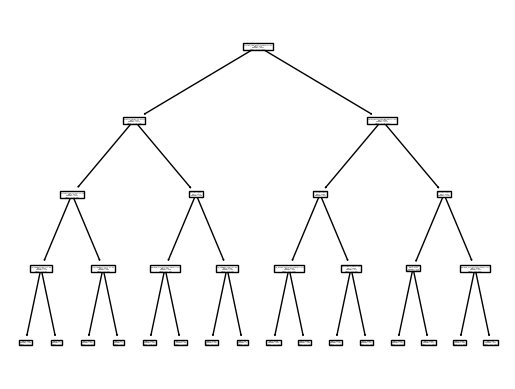

In [55]:
plot_tree(clf,feature_names=X_cols)
plt.show()

In [56]:
#accuracy score using model 1
accuracy_score(train[Y_cols], model1_preds)

0.7933045904133909

In [57]:
####### Model2 #######

In [58]:
clf1 = DecisionTreeClassifier(max_depth=5)

In [59]:
clf1

DecisionTreeClassifier(max_depth=5)

In [60]:
#fit the thing
#clf.fit not assinged to any variable 
#clf.fit changes the object itself
#which means it is ready to use.
clf1.fit(train[X_cols], train[Y_cols])

DecisionTreeClassifier(max_depth=5)

In [61]:
#use the thing
model2_preds = clf1.predict(train[X_cols])

In [62]:
#accuracy score using model 2
accuracy_score(train[Y_cols], model2_preds)

0.8011666243976667

In [63]:
######### Model 3 ###########

In [64]:
clf2 = DecisionTreeClassifier(max_depth=6)

In [65]:
clf2

DecisionTreeClassifier(max_depth=6)

In [66]:
clf2.fit(train[X_cols], train[Y_cols])

DecisionTreeClassifier(max_depth=6)

In [67]:
#use the thing
model3_preds = clf2.predict(train[X_cols])

In [68]:
#accuracy score using model 3
accuracy_score(train[Y_cols], model3_preds)

0.8158762363682476

In [69]:
print(f'Train accuracy score for model 1: {accuracy_score(train[Y_cols], model1_preds):.2%}')
print(f'Train accuracy score for model 2: {accuracy_score(train[Y_cols], model2_preds):.2%}')
print(f'Train accuracy score for model 3: {accuracy_score(train[Y_cols], model3_preds):.2%}')

Train accuracy score for model 1: 79.33%
Train accuracy score for model 2: 80.12%
Train accuracy score for model 3: 81.59%


In [70]:
confusion_matrix(train[Y_cols], model1_preds)

array([[2602,  295],
       [ 520,  526]])

In [71]:
confusion_matrix(train[Y_cols], model2_preds)

array([[2502,  395],
       [ 389,  657]])

In [72]:
confusion_matrix(train[Y_cols], model3_preds)

array([[2579,  318],
       [ 408,  638]])

In [73]:
pd.crosstab(train[Y_cols], model3_preds)

col_0,0,1
churn_yes,,
0,2579,318
1,408,638


In [74]:
#### which model performs better on validate set ###
X_val, Y_val, = validate[X_cols], validate[Y_cols]

In [90]:
Y_val

720     1
5832    1
4378    0
5553    0
482     1
       ..
4506    0
1602    1
583     0
6134    0
3333    0
Name: churn_yes, Length: 1691, dtype: uint8

In [75]:
clf.score(X_val, Y_val)

0.7983441750443524

In [76]:
clf1.score(X_val, Y_val)

0.7983441750443524

In [77]:
clf2.score(X_val, Y_val)

0.794795978710822

In [78]:
print(f'Model 1t: {accuracy_score(train[Y_cols], model1_preds):.2%}')
print(f'Model 1v: {clf.score(X_val, Y_val):.2%}')

print(f'Model 2t: {accuracy_score(train[Y_cols], model2_preds):.2%}')
print(f'Model 2v: {clf1.score(X_val, Y_val):.2%}')

print(f'Model 3t: {accuracy_score(train[Y_cols], model3_preds):.2%}')
print(f'Model 3v: {clf2.score(X_val, Y_val):.2%}')

print(f'Baseline accuracy {baseline_accuracy:.2%}')


Model 1t: 79.33%
Model 1v: 79.83%
Model 2t: 80.12%
Model 2v: 79.83%
Model 3t: 81.59%
Model 3v: 79.48%
Baseline accuracy 73.46%


In [80]:
clf.score(X_val, Y_val) - accuracy_score(train[Y_cols], model1_preds)

0.005039584630961547

In [81]:
accuracy_score(train[Y_cols], model2_preds) - clf1.score(X_val, Y_val)

0.002822449353314327

In [82]:
accuracy_score(train[Y_cols], model3_preds) - clf2.score(X_val, Y_val)

0.021080257657425605

In [84]:
#### best model on test set ###
X_test, Y_test, = test[X_cols], test[Y_cols]

In [86]:
print(f'Model 2t: {accuracy_score(train[Y_cols], model2_preds):.2%}')
print(f'Model 2v: {clf1.score(X_val, Y_val):.2%}')
print(f'Model 2test: {clf1.score(X_test, Y_test):.2%}')

Model 2t: 80.12%
Model 2v: 79.83%
Model 2test: 79.21%
